
# 🏥 Analyse et Prédiction des Déchets Hospitaliers

## Objectifs
- Analyser les données des déchets hospitaliers.
- Implémenter et comparer au moins 4 modèles de machine learning pour prédire le coût de traitement.
- Sauvegarder le meilleur modèle pour l'application web.
- Mettre en place un pipeline de prédiction complet.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configuration
sns.set(style="whitegrid")
%matplotlib inline

# Création du dossier pour les modèles
MODELS_DIR = "../../web_app/models"
os.makedirs(MODELS_DIR, exist_ok=True)


## 1. Chargement et Aperçu des Données

In [2]:

DATA_PATH = "../data/dechets_hospitaliers.csv"
df = pd.read_csv(DATA_PATH)

print(f"Dimensions du dataset : {df.shape}")
display(df.head())


Dimensions du dataset : (735, 16)


,id,hopital,pays,region,type_dechet,poids_kg,cout_traitement,niveau_risque,mode_elimination,date_collecte,distance_traitement_km,conformite,type_conteneur,incident,entreprise_transport,service_origine
0,571,Hôpital Régional de Thiès,Sénégal,Fatick,Radioactifs,201.49,32767.38,Moyen,Incinération,2023-03-30,54.89,Non,Sac rouge,Non,SafeWaste,Radiologie
1,241,Hôpital Laquintinie de Douala,Cameroun,Centre,Piqûres/Coupures,214.32,26431.70,Élevé,Autoclave,2024-07-07,86.71,En attente,Sac rouge,Non,CleanMed,Urgences
2,294,Hôpital Dogta-Lafiè,Togo,Centrale,Organiques,17.56,423.84,Faible,Enfouissement,2024-09-18,86.09,Partielle,Conteneur rigide,Non,NaN,Restauration
3,670,CHR Lomé Commune,Togo,Savanes,Piqûres/Coupures,39.35,4702.25,Élevé,Autoclave,2023-01-08,25.31,En attente,Sac rouge,Non,Hopital Service,Chirurgie
4,475,CHR Dapaong,Togo,Savanes,Pharmaceutiques,243.51,55352.35,Élevé,Incinération,2023-03-11,29.23,NaN,Sac jaune,Non,SafeWaste,Oncologie


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      735 non-null    int64  
 1   hopital                 735 non-null    object 
 2   pays                    735 non-null    object 
 3   region                  735 non-null    object 
 4   type_dechet             735 non-null    object 
 5   poids_kg                735 non-null    float64
 6   cout_traitement         735 non-null    float64
 7   niveau_risque           735 non-null    object 
 8   mode_elimination        735 non-null    object 
 9   date_collecte           735 non-null    object 
 10  distance_traitement_km  735 non-null    float64
 11  conformite              677 non-null    object 
 12  type_conteneur          735 non-null    object 
 13  incident                735 non-null    object 
 14  entreprise_transport    663 non-null    ob

## 2. Analyse Exploratoire (EDA)

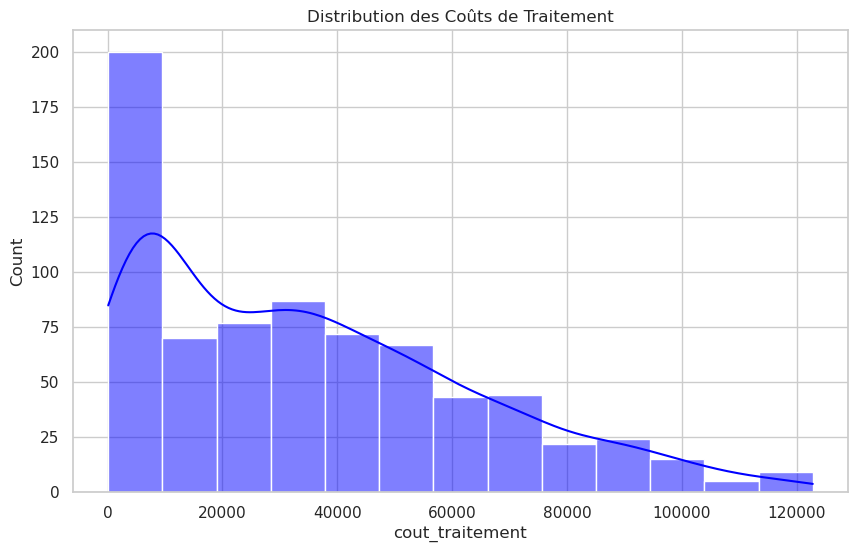

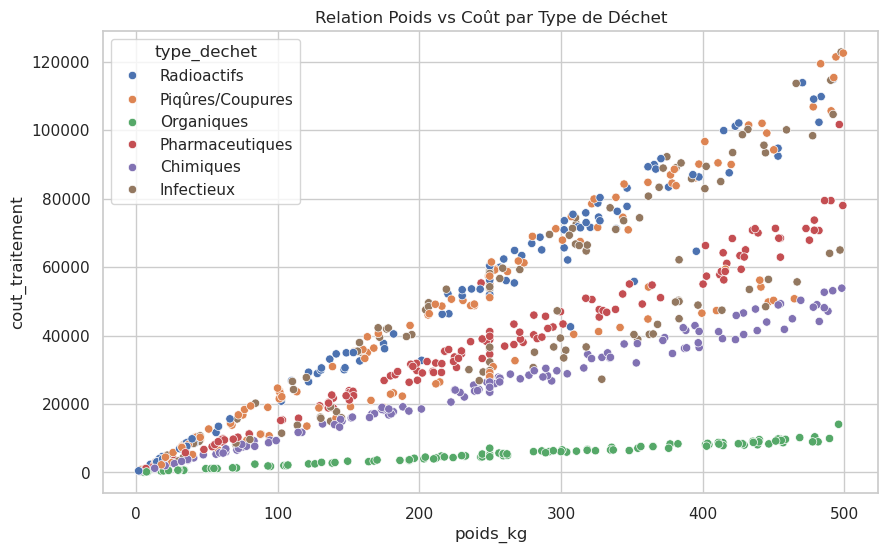

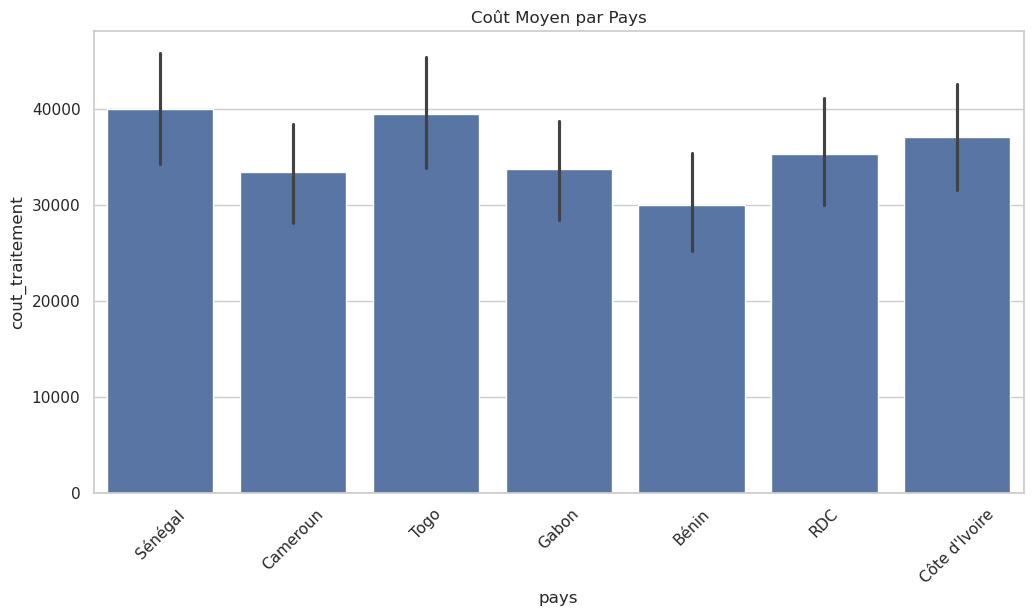

In [14]:

# Distribution de la variable cible (Coût)
plt.figure(figsize=(10, 6))
sns.histplot(df['cout_traitement'], kde=True, color='blue')
plt.title('Distribution des Coûts de Traitement')
plt.show()

# Relation Poids vs Coût
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='poids_kg', y='cout_traitement', hue='type_dechet')
plt.title('Relation Poids vs Coût par Type de Déchet')
plt.show()

# Coût moyen par Pays
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='pays', y='cout_traitement', estimator=np.mean)
plt.title('Coût Moyen par Pays')
plt.xticks(rotation=45)
plt.show()


## 2.1. Analyse Détaillée des Variables


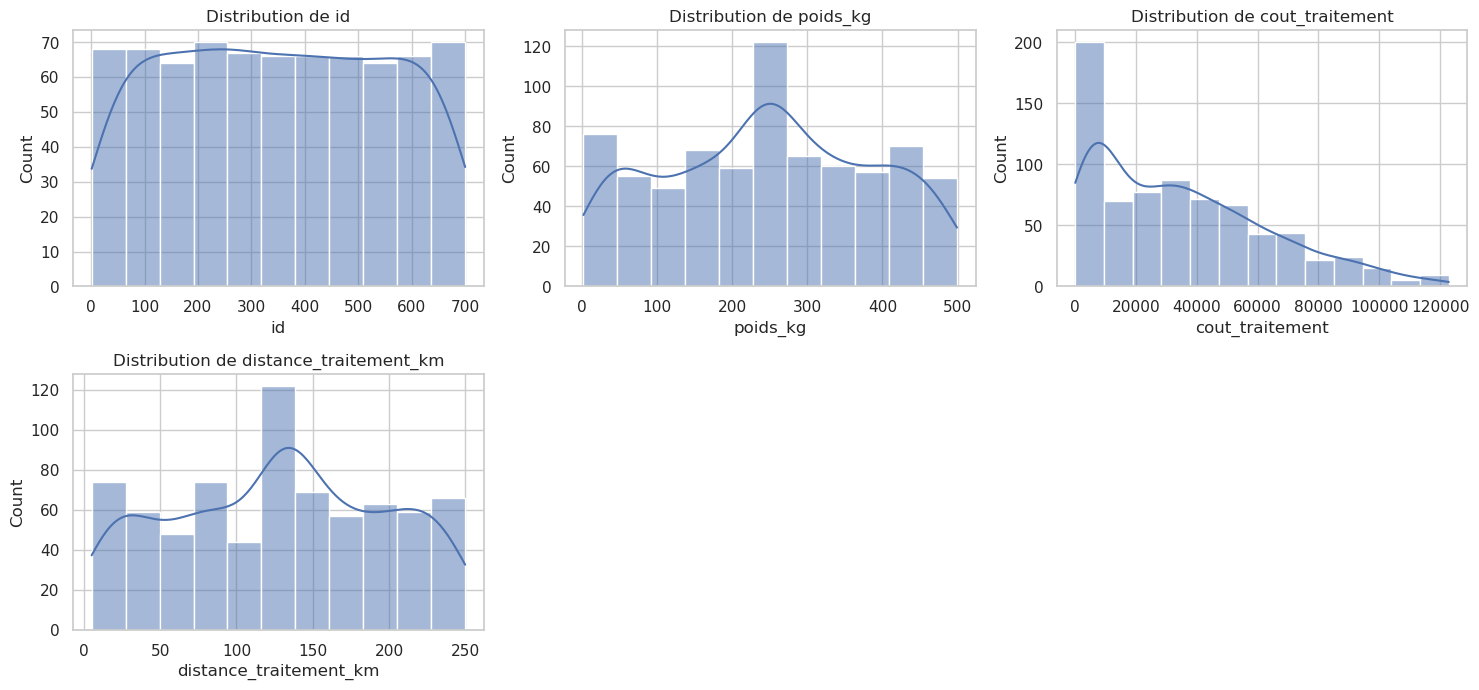

In [15]:

# Création du dossier results s'il n'existe pas
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Histogrammes des variables numériques
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'histograms_numeric.png'))
plt.show()



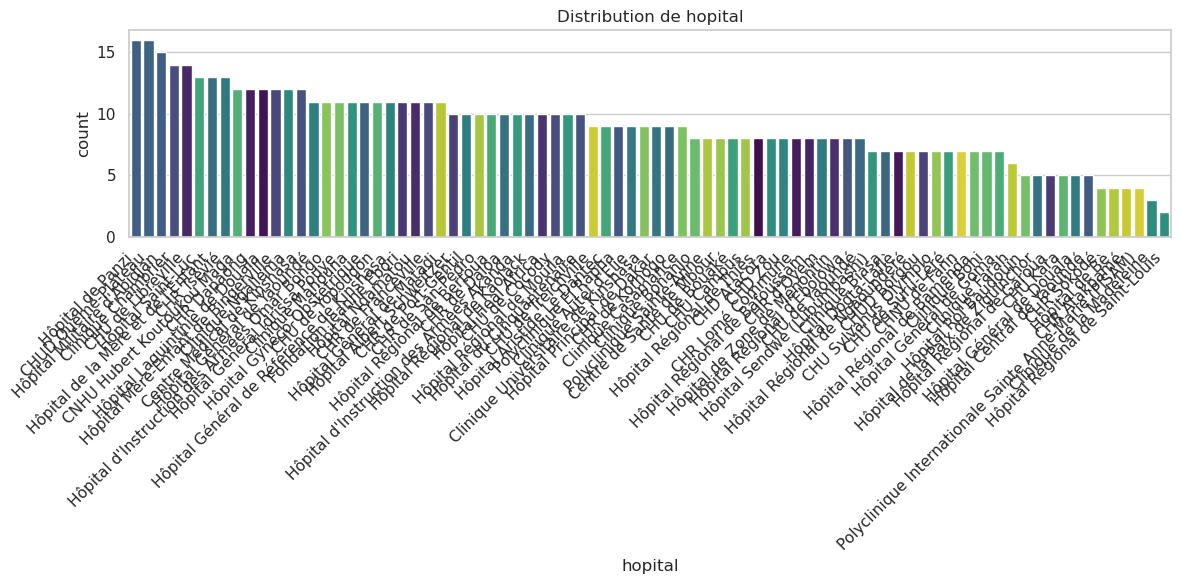

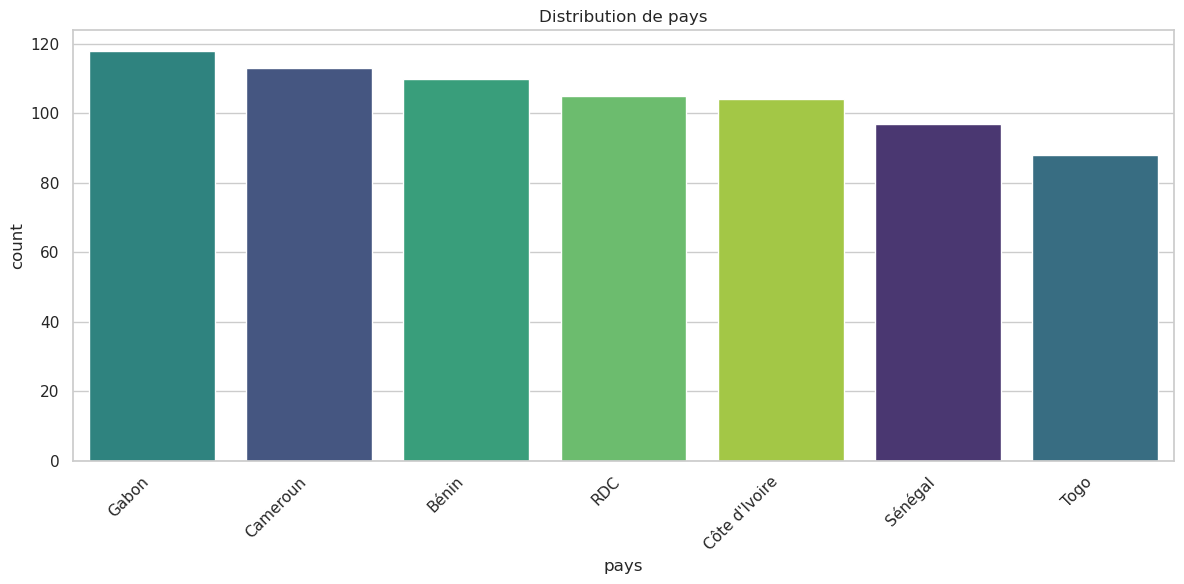

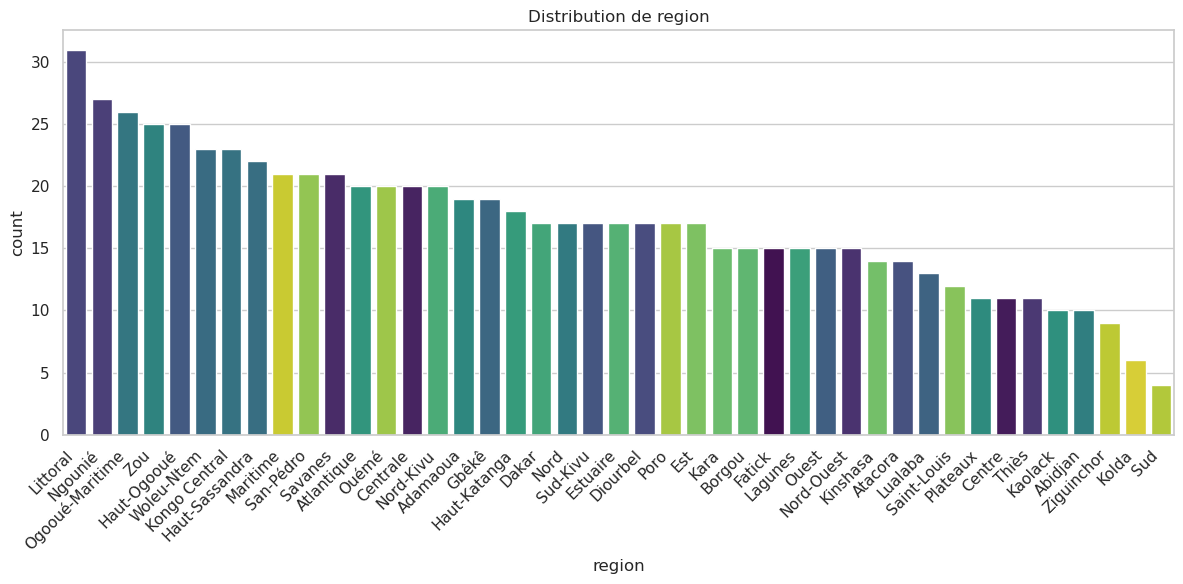

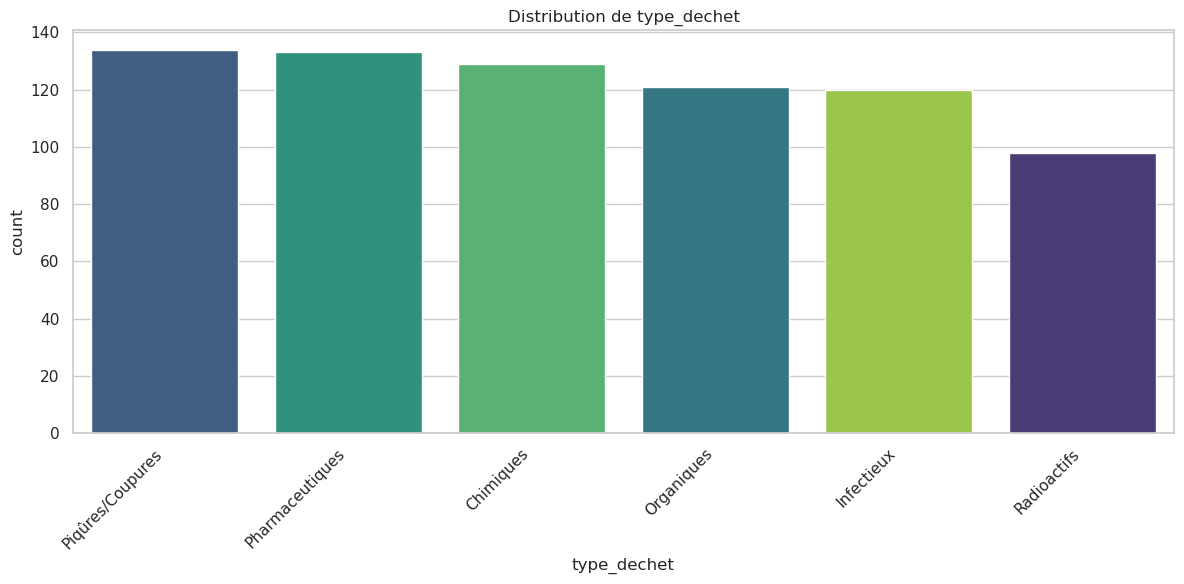

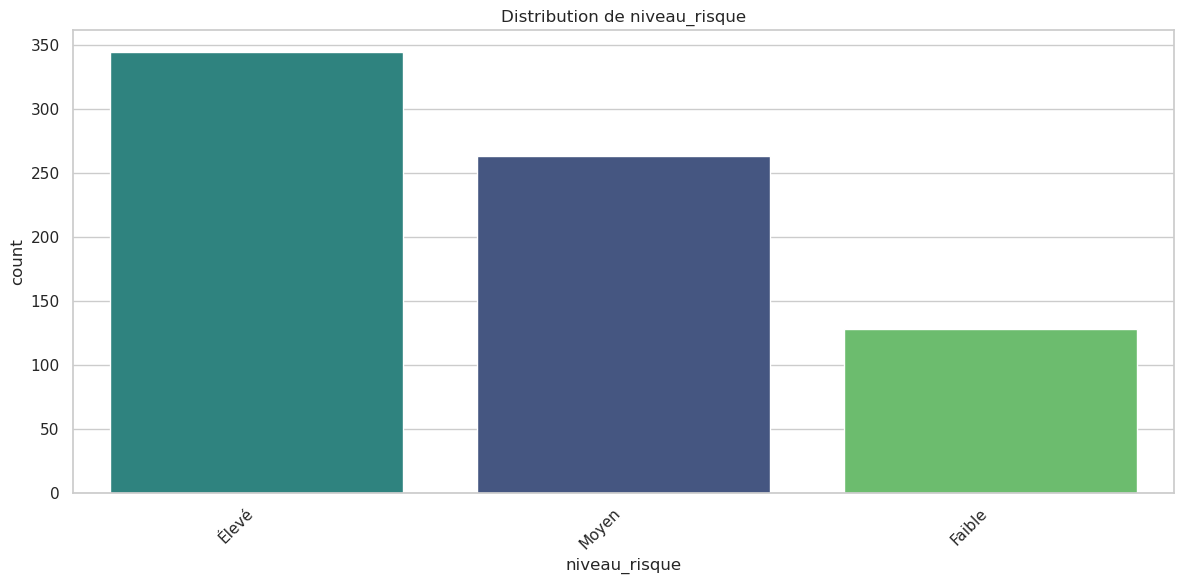

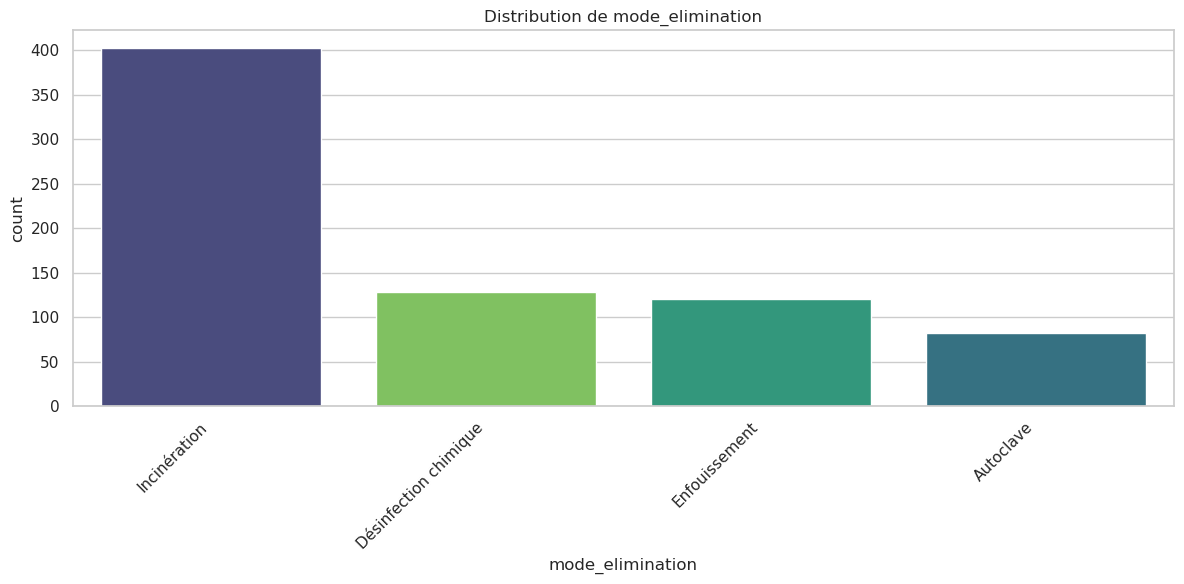

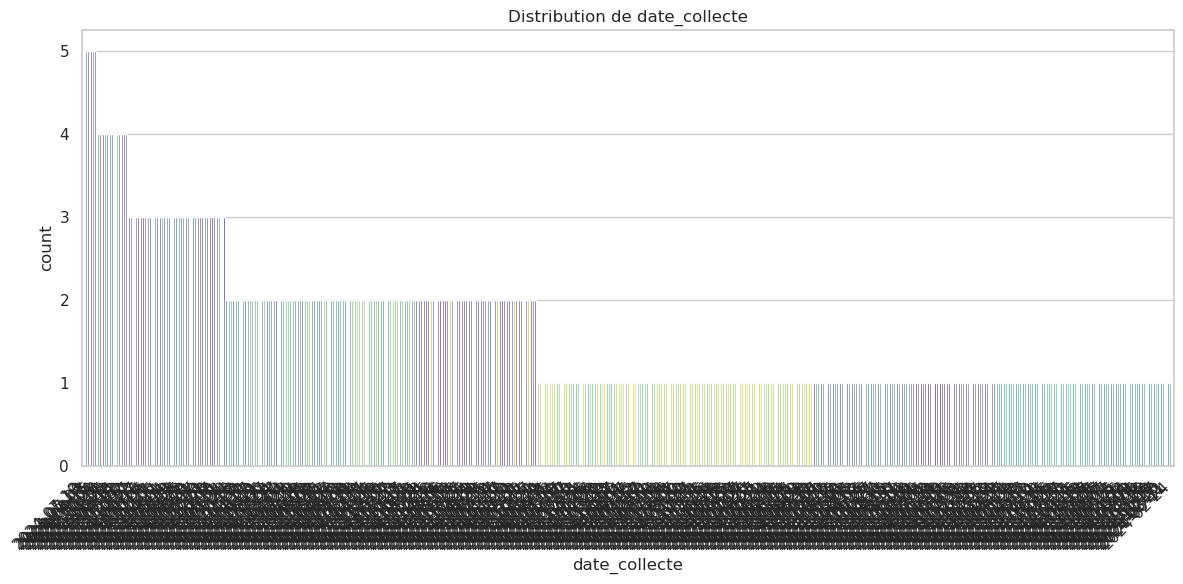

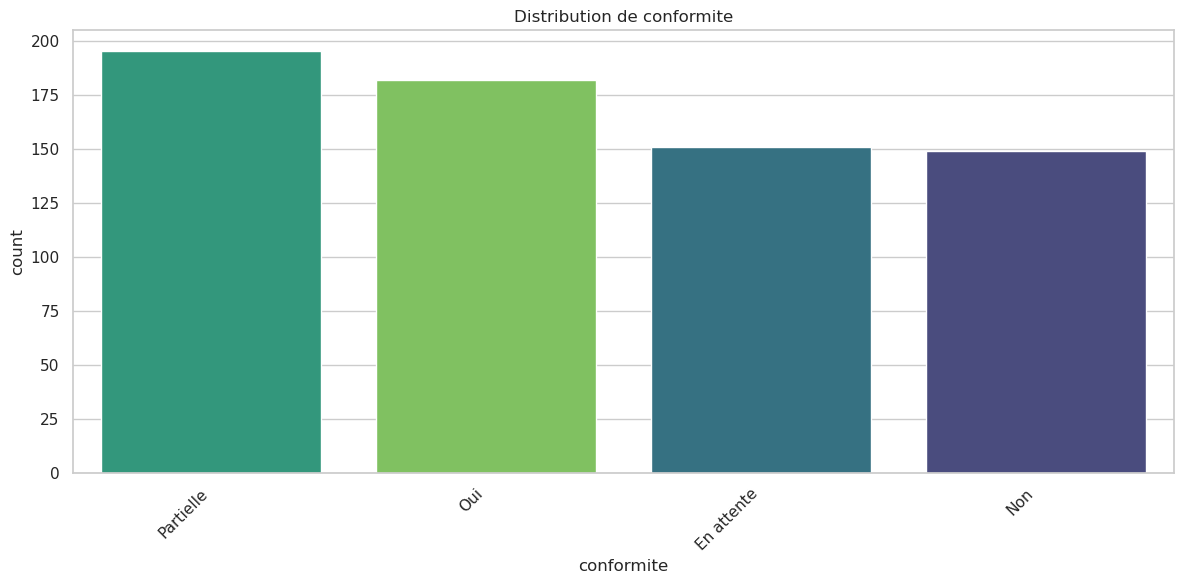

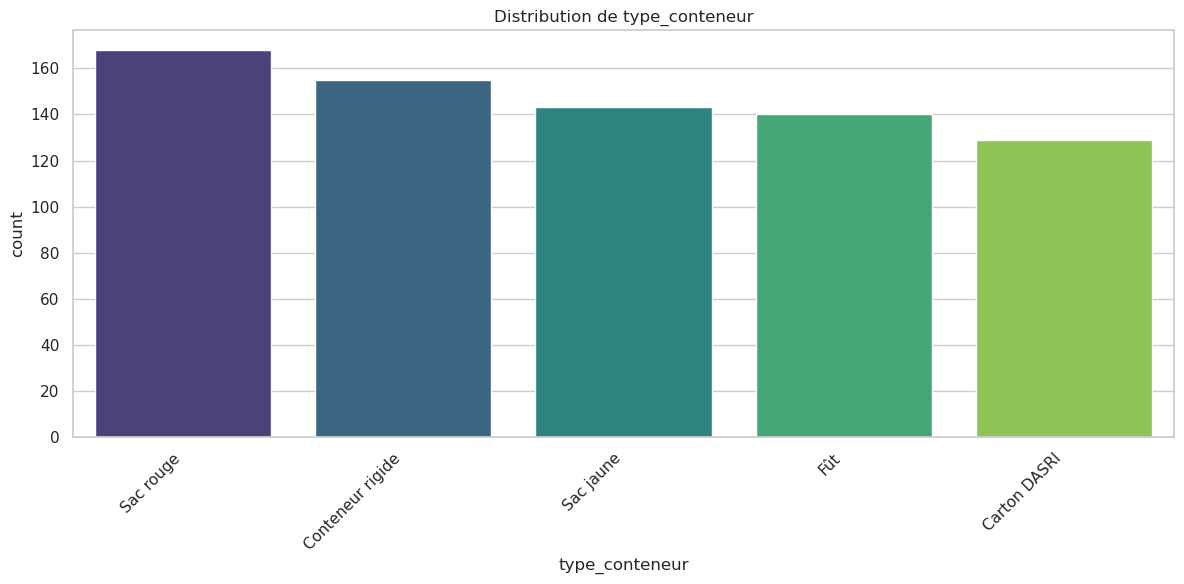

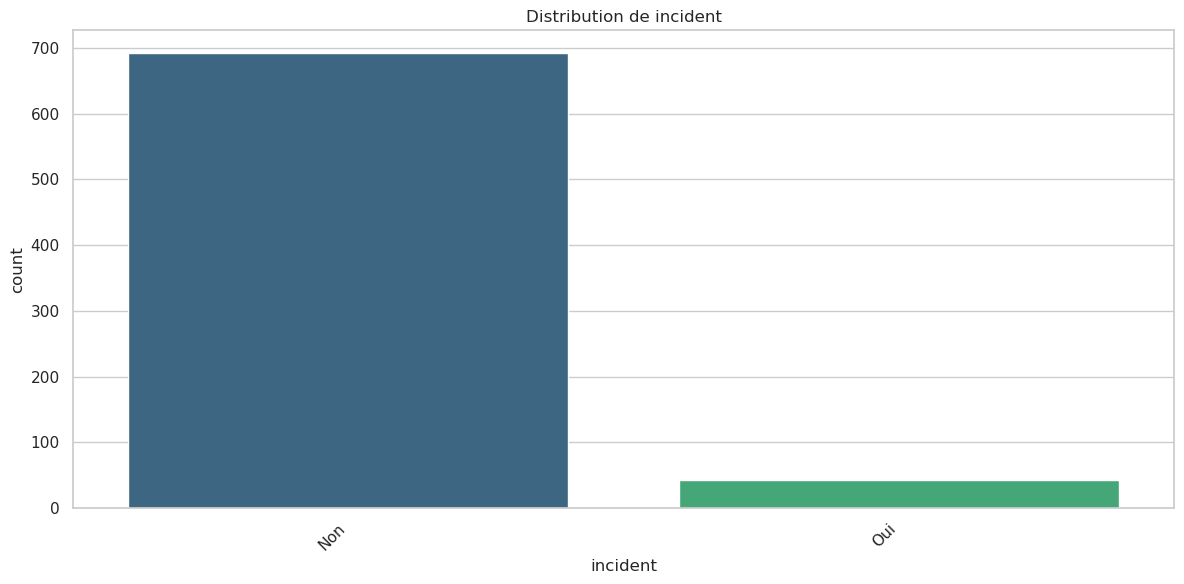

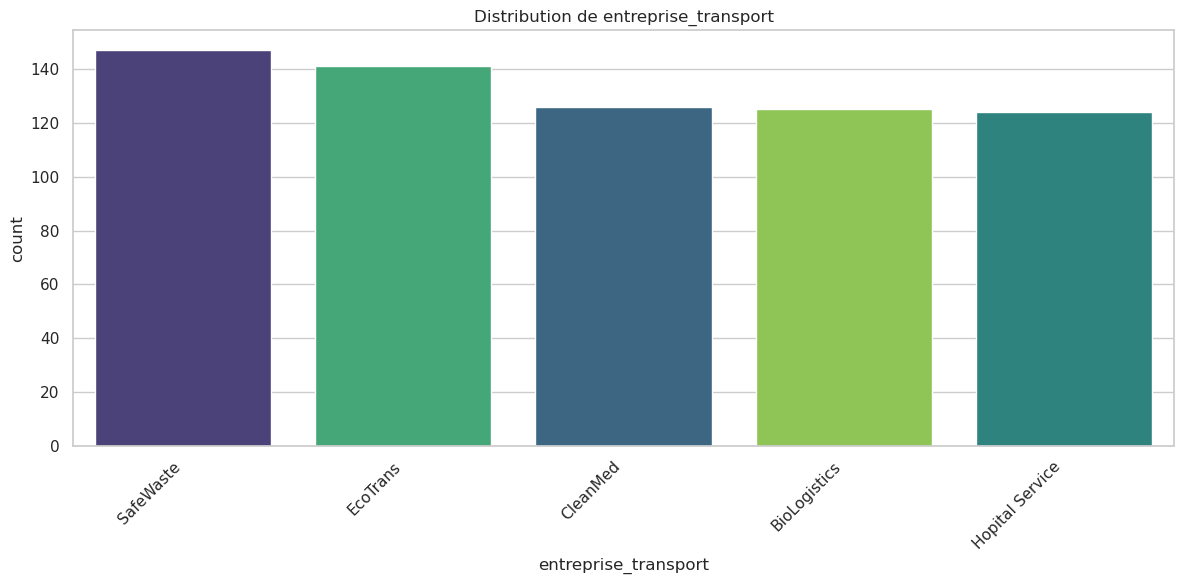

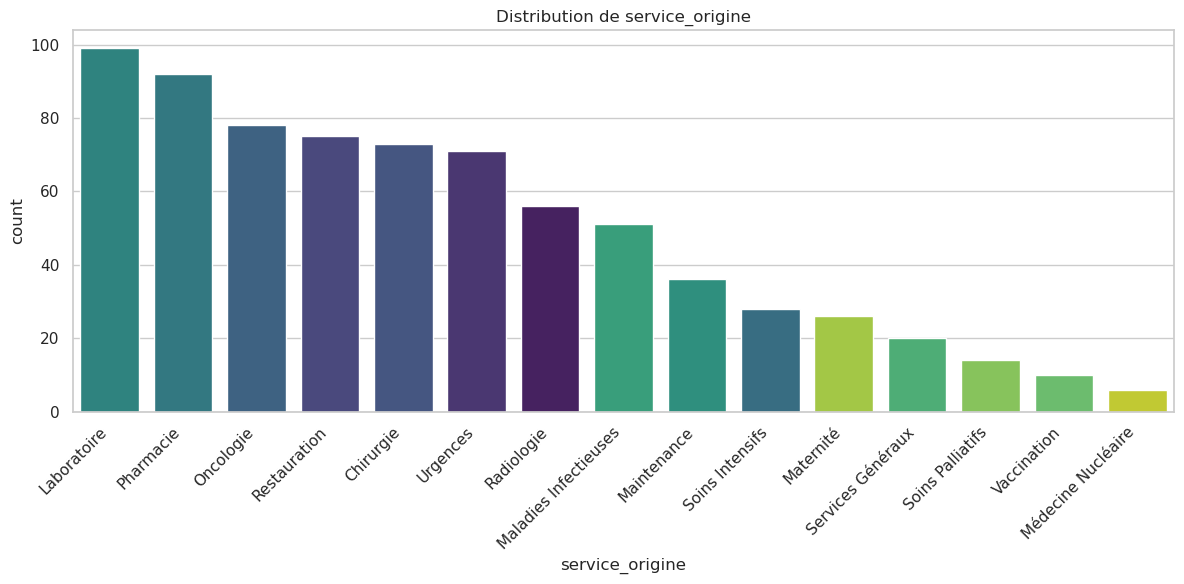

In [17]:

# Barplots des variables catégorielles
categorical_cols_for_eda = df.select_dtypes(include='object').columns.tolist()
# Exclure 'id' et 'date_collecte' pour ces barplots si elles ne sont pas pertinentes pour la distribution
categorical_cols_for_eda = [col for col in categorical_cols_for_eda if col not in ['id']]

for col in categorical_cols_for_eda:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, hue=col, legend=False, order=df[col].value_counts().index, palette='viridis')
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'barplot_{col}.png'))
    plt.show()



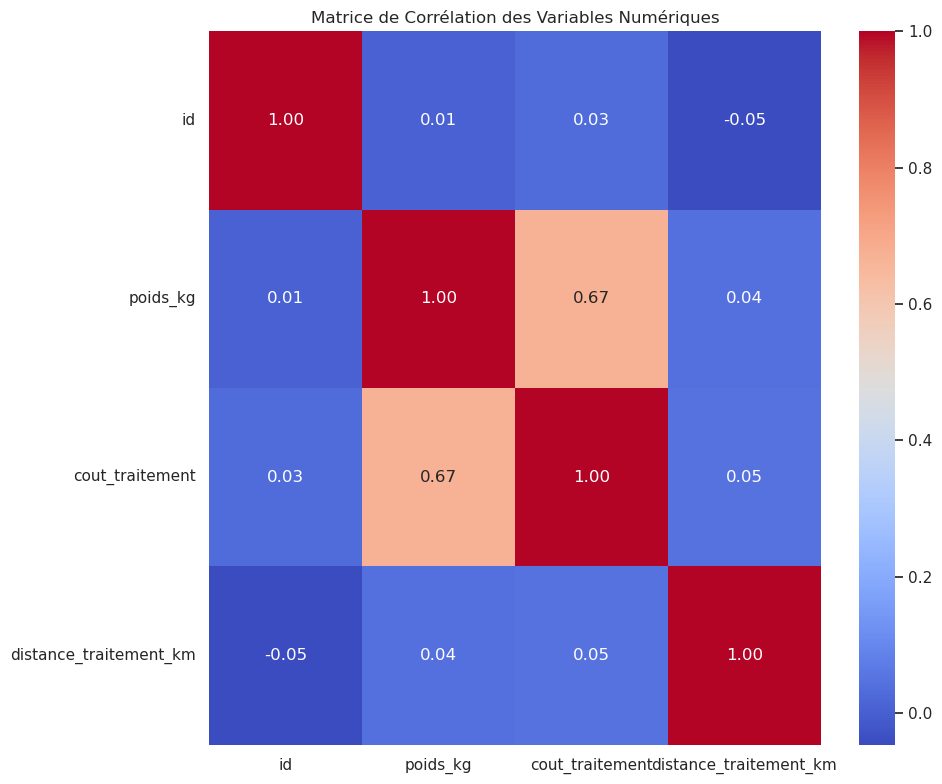

In [18]:

# Matrice de corrélation pour les variables numériques
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation des Variables Numériques')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'correlation_heatmap.png'))
plt.show()



## 3. Préparation des Données

In [19]:

# Séparation Features / Target
# Nous voulons prédire 'cout_traitement'
# Nous utilisons 'poids_kg', 'distance_traitement_km', 'type_dechet', 'niveau_risque', 'pays', 'region' comme features.
# 'hopital' est potentiellement trop spécifique (cardinalité élevée), mais nous pouvons l'inclure si nous pensons qu'il y a un biais par hôpital.
# Pour ce modèle généraliste, nous allons ignorer 'hopital' et 'date_collecte' (sauf si feature engineering sur le mois).

X = df[['poids_kg', 'distance_traitement_km', 'type_dechet', 'niveau_risque', 'pays', 'region', 'type_conteneur']]
y = df['cout_traitement']

# Gestion des valeurs manquantes (si présentes)
# Variables numériques
numeric_features = ['poids_kg', 'distance_traitement_km']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Variables catégorielles
categorical_features = ['type_dechet', 'niveau_risque', 'pays', 'region', 'type_conteneur']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Préprocesseur global
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)


Shape X_train: (588, 7)
Shape y_train: (588,)


## 4. Modélisation et Comparaison

In [7]:

# Définition des 4 modèles
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}

print("Entraînement des modèles en cours...")
for name, model in models.items():
    # Création du pipeline complet
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Entraînement
    clf.fit(X_train, y_train)
    
    # Prédiction
    y_pred = clf.predict(X_test)
    
    # Évaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'Model': clf}
    
    print(f"✅ {name}: RMSE={rmse:.2f}, R2={r2:.3f}")



Entraînement des modèles en cours...
✅ LinearRegression: RMSE=14439.82, R2=0.754
✅ RandomForest: RMSE=11492.57, R2=0.844
✅ GradientBoosting: RMSE=11035.47, R2=0.856
✅ SVR: RMSE=30969.79, R2=-0.131


## 6.1. Sauvegarde des performances en CSV


In [8]:

# Charger le JSON de performances et le sauvegarder en CSV
import json
import pandas as pd

perf_path = os.path.join(MODELS_DIR, 'performances.json')
with open(perf_path, 'r') as f:
    perf_dict = json.load(f)

# Convertir en DataFrame
summary_df = pd.DataFrame(perf_dict).T

# Sauvegarder en CSV dans le dossier results
summary_csv_path = os.path.join(RESULTS_DIR, 'summary_performance.csv')
summary_df.to_csv(summary_csv_path, index=True)
print(f"Performances récapitulatives sauvegardées sous : {summary_csv_path}")



Performances récapitulatives sauvegardées sous : ../results/summary_performance.csv


## 7. Entraînement des Classifieurs Annexes (Risque, Élimination)


In [9]:

from sklearn.ensemble import RandomForestClassifier

# Prédire 'niveau_risque'
y_risk = df['niveau_risque']
# Simuler des features
clf_risk = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=50))])
clf_risk.fit(X_train, df.loc[X_train.index, 'niveau_risque'])
joblib.dump(clf_risk, os.path.join(MODELS_DIR, 'model_risk.pkl'))
print("Modèle Risque sauvegardé.")

# Prédire 'mode_elimination'
y_mode = df['mode_elimination']
clf_mode = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=50))])
clf_mode.fit(X_train, df.loc[X_train.index, 'mode_elimination'])
joblib.dump(clf_mode, os.path.join(MODELS_DIR, 'model_mode.pkl'))
print("Modèle Mode Élimination sauvegardé.")



Modèle Risque sauvegardé.
Modèle Mode Élimination sauvegardé.


## 5. Visualisation des Performances

## 7.1. Visualisation des performances des classifieurs


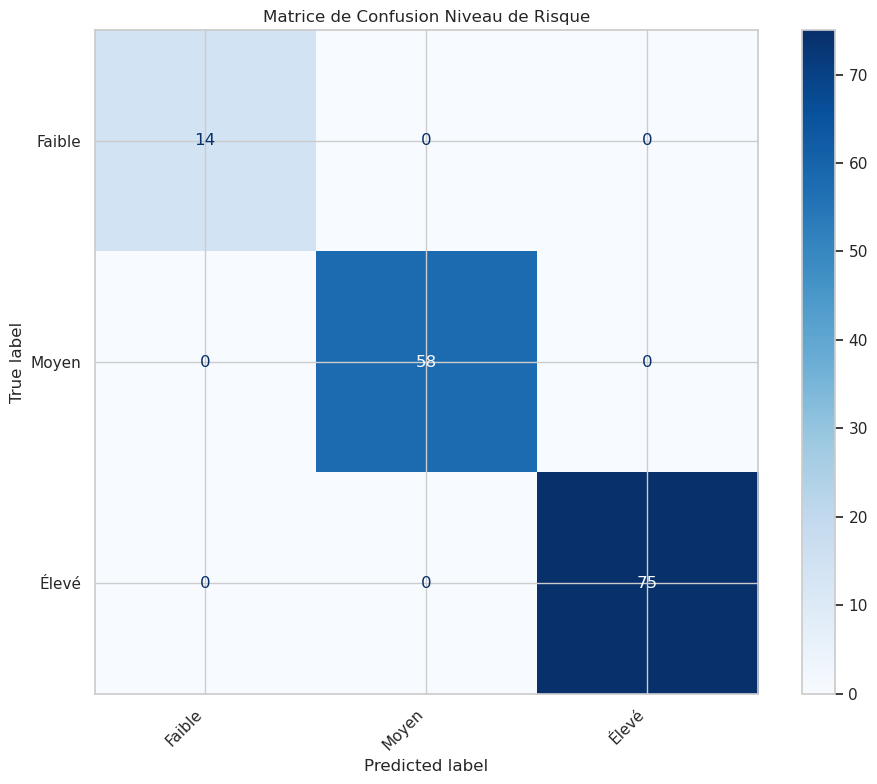

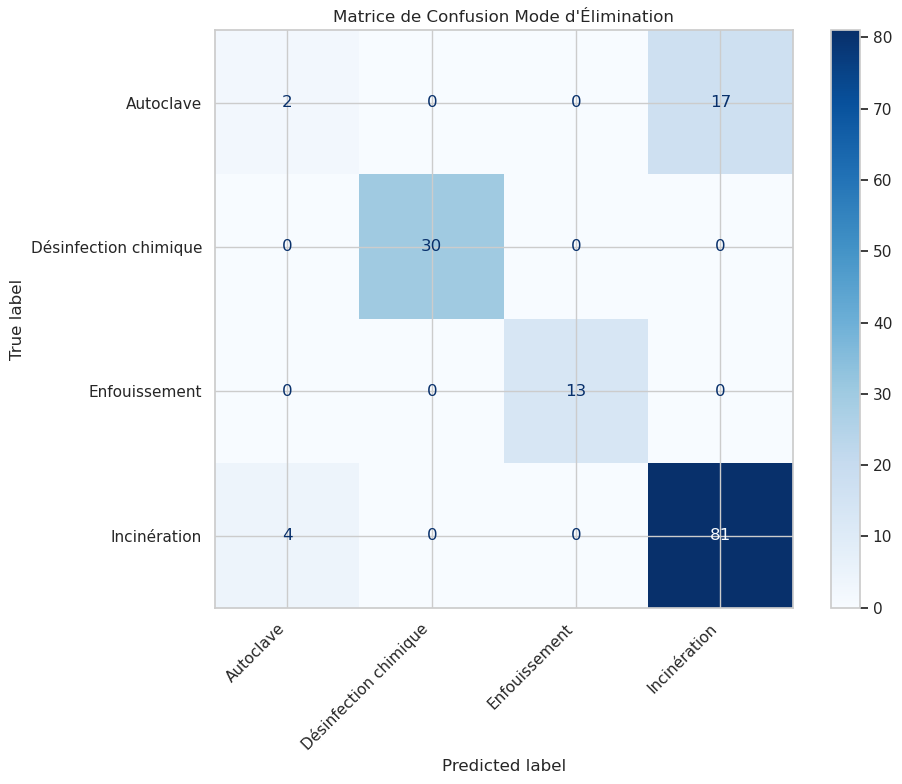

In [10]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()

# Prédiction pour les modèles de classification
y_risk_pred = clf_risk.predict(X_test)
y_mode_pred = clf_mode.predict(X_test)

# Matrice de confusion pour niveau_risque
risk_labels = sorted(df['niveau_risque'].unique())
plot_confusion_matrix(df.loc[X_test.index, 'niveau_risque'], y_risk_pred, risk_labels, 'Matrice de Confusion Niveau de Risque', 'confusion_risque.png')

# Matrice de confusion pour mode_elimination
mode_labels = sorted(df['mode_elimination'].unique())
plot_confusion_matrix(df.loc[X_test.index, 'mode_elimination'], y_mode_pred, mode_labels, 'Matrice de Confusion Mode d\'Élimination', 'confusion_elimination.png')

# Si tu veux aussi un classifieur pour type_dechet, tu devras l'entraîner avant de générer sa matrice de confusion
# Exemple pour type_dechet (à entraîner d'abord):
# y_type = df['type_dechet']
# clf_type = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', RandomForestClassifier(n_estimators=50))])
# clf_type.fit(X_train, df.loc[X_train.index, 'type_dechet'])
# joblib.dump(clf_type, os.path.join(MODELS_DIR, 'model_type.pkl'))
# y_type_pred = clf_type.predict(X_test_processed)
# type_labels = sorted(df['type_dechet'].unique())
# plot_confusion_matrix(df.loc[X_test.index, 'type_dechet'], y_type_pred, type_labels, 'Matrice de Confusion Type de Déchet', 'confusion_type.png')




,RMSE,R2,MAE
LinearRegression,14439.81929,0.754116,11220.592327
RandomForest,11492.574274,0.844245,6813.226417
GradientBoosting,11035.469741,0.856389,7058.141499
SVR,30969.794502,-0.131055,23896.171693


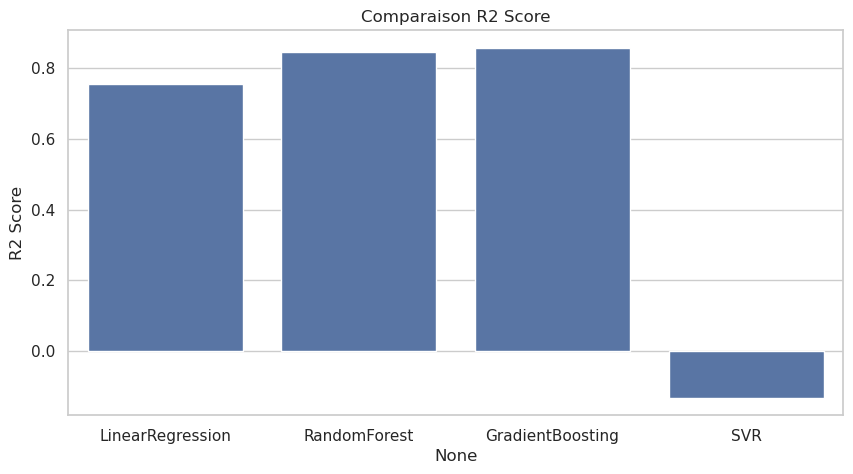

In [11]:

res_df = pd.DataFrame(results).T.drop('Model', axis=1) # Exclure l'objet modèle pour l'affichage
display(res_df)

# Graphique R2
plt.figure(figsize=(10, 5))
sns.barplot(x=res_df.index, y=res_df['R2'].astype(float))
plt.title('Comparaison R2 Score')
plt.ylabel('R2 Score')
plt.show()


## 6. Sauvegarde du Meilleur Modèle

In [12]:

# Identifier le meilleur modèle (basé sur R2)
best_model_name = res_df['R2'].astype(float).idxmax()
best_pipeline = results[best_model_name]['Model']

print(f"🏆 Le meilleur modèle est : {best_model_name}")

# Sauvegarder le modèle
model_path = os.path.join(MODELS_DIR, 'best_model_cout.pkl')
joblib.dump(best_pipeline, model_path)
print(f"Modèle sauvegardé sous : {model_path}")

# Sauvegarder aussi les performances pour l'app web
import json
perf_path = os.path.join(MODELS_DIR, 'performances.json')
# Convertir l'index et les valeurs float pour JSON
perf_dict = res_df.to_dict(orient='index')
with open(perf_path, 'w') as f:
    json.dump(perf_dict, f, indent=4)
print(f"Performances sauvegardées sous : {perf_path}")


🏆 Le meilleur modèle est : GradientBoosting
Modèle sauvegardé sous : ../../web_app/models/best_model_cout.pkl
Performances sauvegardées sous : ../../web_app/models/performances.json


## 7. Entraînement des Classifieurs Annexes (Risque, Élimination)

In [13]:

from sklearn.ensemble import RandomForestClassifier

# Prédire 'niveau_risque'
y_risk = df['niveau_risque']
# Simuler des features
clf_risk = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=50))])
clf_risk.fit(X_train, df.loc[X_train.index, 'niveau_risque'])
joblib.dump(clf_risk, os.path.join(MODELS_DIR, 'model_risk.pkl'))
print("Modèle Risque sauvegardé.")

# Prédire 'mode_elimination'
y_mode = df['mode_elimination']
clf_mode = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=50))])
clf_mode.fit(X_train, df.loc[X_train.index, 'mode_elimination'])
joblib.dump(clf_mode, os.path.join(MODELS_DIR, 'model_mode.pkl'))
print("Modèle Mode Élimination sauvegardé.")


Modèle Risque sauvegardé.
Modèle Mode Élimination sauvegardé.
